In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from proofreader.utils.io import read_cremi_volume, from_h5
%load_ext autoreload
%autoreload 2

In [ ]:
import matplotlib.pyplot as plt
import IPython

def view_volume(volume, fig_size=6.5):
    length = volume.shape[0]

    # set up
    fig = plt.figure()
    fig.set_size_inches(fig_size, fig_size)
    axes = fig.add_subplot()
    hfig = display(fig, display_id=True)

    # display
    for i in range(length):
        axes.imshow(volume[i], cmap='gray', interpolation='none',
                    filternorm=False, resample=False)
        fig.canvas.draw()
        hfig.update(fig)
        if i != length-1:
            plt.cla()
    # clean up
    IPython.display.clear_output()


In [276]:
trueA = read_cremi_volume('A',seg=True, path='../../dataset/cremi')
trueB = read_cremi_volume('B',seg=True, path='../../dataset/cremi')
trueC = read_cremi_volume('C',seg=True, path='../../dataset/cremi')

In [277]:
import cc3d

# Clean C
# some slices are totally mislabeled
def clean_true_c(vol):
    assert vol.shape[0] == 125, 'vol may have already been cleaned'
    return np.delete(vol, [14,74], 0)

trueC = clean_true_c(trueC)
print(trueC.shape)
# some neurites of same label are not connected
trueC = cc3d.connected_components(trueC)


(123, 1250, 1250)


In [278]:
trueA = cc3d.connected_components(trueA)

In [279]:
def get_classes_sorted_by_volume(vol, reverse=False, return_counts=False):

    classes, counts = np.unique(vol, return_counts=True)

    sort_indices = np.argsort(counts)
    if reverse:
        sort_indices = np.flip(sort_indices)
    classes = classes[sort_indices]
    if return_counts:
        counts = counts[sort_indices]
        return classes, counts
    return classes

In [280]:
import random
import numpy as np

def sample_square_radius(vol, radius):
    dims = len(vol.shape)
    if type(radius) != tuple:
        radius = (radius,)*dims
    assert dims == len(radius), 'radius must be specified for each dim of input, or be scalar'

    sample_slice = []
    for d in range(dims):
        r = radius[d]
        s = vol.shape[d]
        x = random.randint(r, s-r)
        sample_slice.append(slice(x-r,x+r))
    sample_slice = tuple(sample_slice)
    return vol[sample_slice]


In [281]:
def get_classes_which_zspan_at_least(vol, num_slices):
    counts = {}
    for i in range(vol.shape[0]):
        slice = vol[i]
        classes = np.unique(slice)
        for c in classes:
            if c in counts:
                 counts[c] += 1
            else:
                counts[c] = 0
    res = []
    for c, cnt in counts.items():
        if cnt >= num_slices + 2:
            res.append(c)
    
    return res
   

In [282]:
import random
import math
import cc3d
from proofreader.utils.all import list_remove
from proofreader.utils.data import arg_where_range, circular_mask, crop_where
from proofreader.utils.vis import view_segmentation, grid_volume
from skimage.color import label2rgb
from skimage.segmentation import find_boundaries
import time

# c:int, label of a neurite in vol to use as source
# example_type:bool True for positive example, False for negative example
# radius:int radius (voxels) on bottom cross section in which to select second neurite
# num_slices:int number of slices to drop
# context_slices:int  max number of slice on top and bottom neurites
def example_from_class(vol, c, example_type, num_slices, radius, context_slices = 10):

    margin = 1 # number of slices that must be left on top after droping slices
    top_c = c
    (sz, sy, sx) = vol.shape

    # Find min and max z slice on which c occurs #
    for i in range(sz):
        if c in vol[i]:
            zmin = i
            break
    for i in reversed(range(sz)):
        if c in vol[i]:
            zmax = i
            break
    assert zmax - zmin >= num_slices + 2 , f'zspan of neurite must be at least 2 slices bigger than num_slices to drop, zspan:{zmax - zmin}, num_slices:{num_slices}'
    # the drop can start at the end of the top nerutie for negative examples
    # but should start earlier such that there is some bottom fragment for postive examples
    z_max_range = zmax-margin-num_slices+1 if example_type else zmax+1
    drop_start = random.randint(zmin+margin, z_max_range) # margin not needed on bottom
    drop_start = z_max_range
    drop_end = min(drop_start+num_slices, vol.shape[0]-1) # take min to ensure there is some bottom vol
    top_z_len = min(context_slices, drop_start-zmin) 
    bot_z_len = min(context_slices, sz-drop_end) 
    
    print('zmin, zmax: ', zmin, zmax)
    print('top_c', top_c)
    print('drop range: ', drop_start, drop_end )
    print('top, bot z_len: ', top_z_len, bot_z_len )

    # Alloc final vol, we dont know how large it will be in y and x but we know max z #
    mz = num_slices + top_z_len + bot_z_len
    final_vol = np.zeros((mz, sy, sx), dtype='uint')

    # Build top section #
    top_vol_section = final_vol[0:top_z_len]
    top_vol_section[vol[drop_start-top_z_len:drop_start] == top_c] = top_c

    # Do connected component relabeling to ensure only one fragment on top #
    top_vol_section_relabeled = cc3d.connected_components(top_vol_section)
    top_classes_relabeled = list(np.unique(top_vol_section_relabeled[-1])) # must select from top border slice
    top_classes_relabeled = list_remove(top_classes_relabeled, 0)
    relabeled_top_c = random.choice(top_classes_relabeled) # select new top class from relabeled top section
    top_vol_section_relabeled[top_vol_section_relabeled != relabeled_top_c] = 0

    # Get midpoint of neurite on 2D top cross section, #
    top_border = top_vol_section_relabeled[-1]
    mins, maxs = arg_where_range(top_border == relabeled_top_c) # use the relabeled top section
    mp_y, mp_x = [(mi+ma)//2 for mi,ma in zip(mins,maxs)] # midpoint

    # Find all neurites with distnce D from that point on bottom cross section #
    bot_border = vol[drop_end].copy() # need copy because we zero
    mask = circular_mask(bot_border.shape[0], bot_border.shape[1], center=(mp_x, mp_y), radius=radius)
    bot_border[~mask] = 0
    mismatch_classes = list(np.unique(bot_border))

    # For positive examples, simply set bottom class to top class #
    if example_type:
        bot_c = top_c
    else:
    # Other wise select bottom class by picking 1 neurite from set of labels in radius #
        assert mismatch_classes[0] == 0, 'first class should be 0, otherwise something went wrong'
        mismatch_classes = list_remove(mismatch_classes, [0, top_c]) # remove 0 and top class lables
        if len(mismatch_classes) == 0:
            print(f'for {example_type} example, could not find bottom label within radius, returning none')
            return None
        # maybe could select here based on on cross-sectional volume
        bot_c = random.choice(mismatch_classes) # select bottom neurite class

    print('top_c, bot_c', top_c, bot_c)

    # Build bot section #
    bot_vol_section = final_vol[num_slices+top_z_len:]
    bot_vol_section[vol[drop_end:drop_end+bot_z_len] == bot_c] = bot_c

    # Do connected component relabeling to ensure only one fragment on bottom #
    # The mask and radius are needed for both positive and negative examples #
    # So that after connected components we can pick a fragment near the top neurite #
    bot_vol_section_relabeled = cc3d.connected_components(bot_vol_section)
    bot_border_relabled = bot_vol_section_relabeled[0]
    relabeled_fragments_in_radius = list(np.unique(bot_border_relabled[mask]))
    relabeled_fragments_in_radius = list_remove(relabeled_fragments_in_radius, 0)
    if len(relabeled_fragments_in_radius) == 0:
        print(f'for {example_type} example, could not find bottom label within radius, returning none')
        return None
    relabeled_bot_c = random.choice(relabeled_fragments_in_radius) # take fragment which is in radius
    bot_vol_section_relabeled[bot_vol_section_relabeled != relabeled_bot_c] = 0


    # Build final volume of top and bottom sections #
    final_vol[0:top_z_len] = top_vol_section_relabeled
    final_vol[num_slices+top_z_len:] = bot_vol_section_relabeled
    
    # Take surfaces of vols and final connected components sanity check #
    # final_vol = find_boundaries(final_vol, mode='inner').astype(np.uint8)
    # final_vol = cc3d.connected_components(final_vol)
    # assert len(np.unique(final_vol)) == 3, 'final sample should have 3 labels, n1, n2, 0'

    return final_vol


In [150]:
num_slices = 3
classes = get_classes_which_zspan_at_least(trueC, num_slices)
print(f'{len(classes)}/{len(np.unique(trueC))}')

872/1978


In [222]:
c = random.choice(list(classes))
example = example_from_class(vol, c, example_type=True, num_slices=num_slices, radius=32)

zmin, zmax:  75 83
top_c 11513
drop range:  80 83
top, bot z_len:  5 10
(5, 1250, 1250)
(5, 1250, 1250)
top_c, bot_c 11513 11513


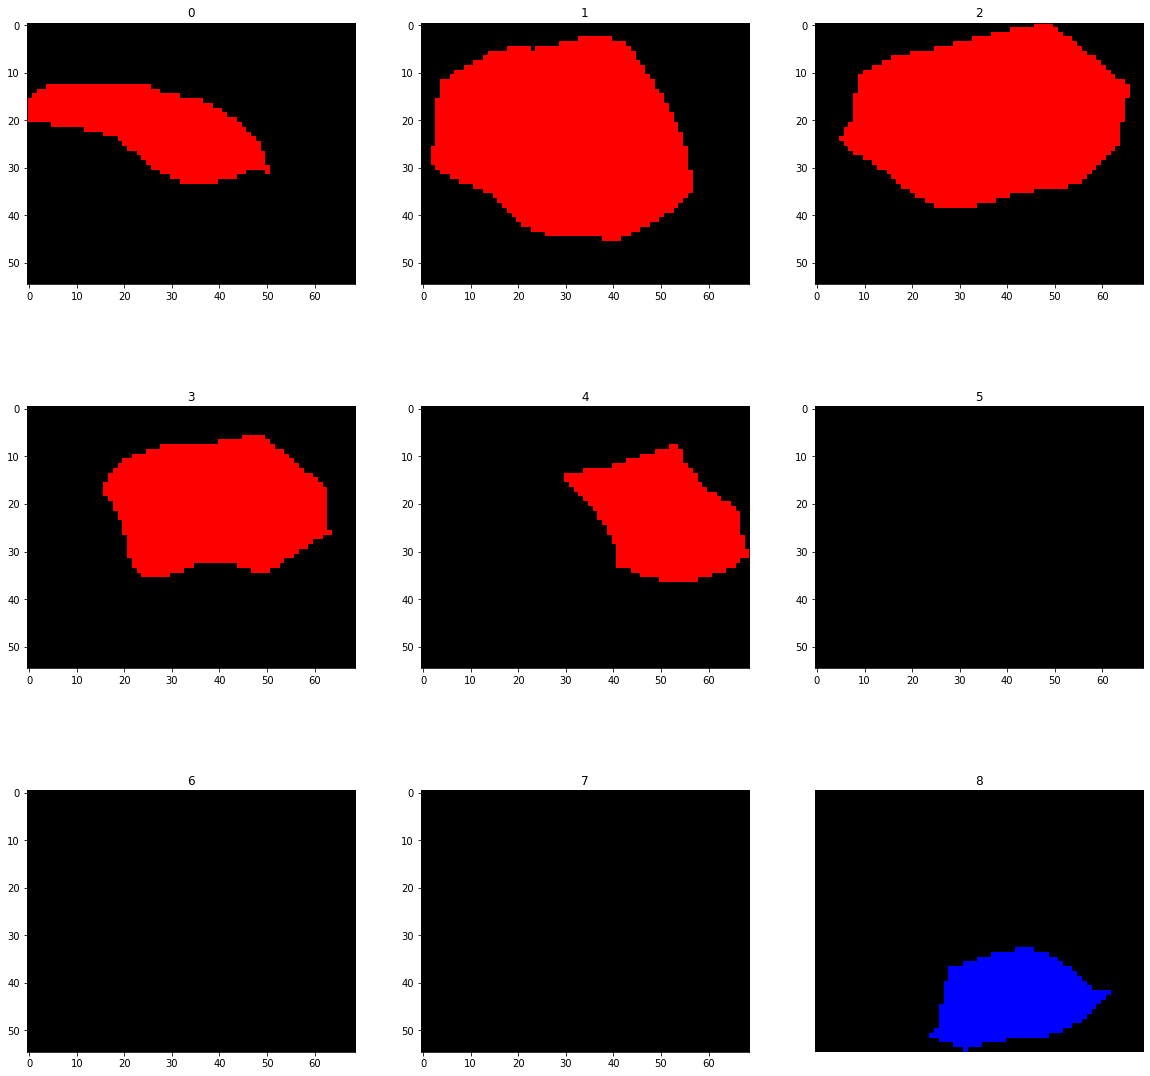

In [223]:
example = crop_where(example, example != 0)
example = cc3d.connected_components(example)
assert len(np.unique(example)) == 3, 'final sample should have 3 labels, n1, n2, 0'
grid_volume(label2rgb(example, bg_label=0),sz=20)

In [283]:
def test_success(vol, c, num_slices, radius, context_slices=10):

    margin = 1 # number of slices that must be left on top after droping slices
    top_c = c
    (sz, sy, sx) = vol.shape

    # Find min and max z slice on which c occurs #
    for i in range(sz):
        if c in vol[i]:
            zmin = i
            break
    for i in reversed(range(sz)):
        if c in vol[i]:
            zmax = i
            break
    assert zmax - zmin >= num_slices + 2 , f'zspan of neurite must be at least 2 slices bigger than num_slices to drop, zspan:{zmax - zmin}, num_slices:{num_slices}'
    # the drop can start at the end of the top nerutie for negative examples
    # but should start earlier such that there is some bottom fragment for postive examples
    z_max_range = zmax-margin-num_slices+1
    drop_start = random.randint(zmin+margin, z_max_range) # margin not needed on bottom
    drop_start = z_max_range
    drop_end = min(drop_start+num_slices, vol.shape[0]-1) # take min to ensure there is some bottom vol
    top_z_len = min(context_slices, drop_start-zmin) 
    bot_z_len = min(context_slices, sz-drop_end) 

    # Alloc final vol, we dont know how large it will be in y and x but we know max z #
    mz = num_slices + top_z_len + bot_z_len
    final_vol = np.zeros((mz, sy, sx), dtype='uint')

    # Build top section #
    top_vol_section = final_vol[0:top_z_len]
    top_vol_section[vol[drop_start-top_z_len:drop_start] == top_c] = top_c

    # Do connected component relabeling to ensure only one fragment on top #
    top_vol_section_relabeled = cc3d.connected_components(top_vol_section)
    top_classes_relabeled = list(np.unique(top_vol_section_relabeled[-1])) # must select from top border slice
    top_classes_relabeled = list_remove(top_classes_relabeled, 0)

    if len(top_classes_relabeled) == 0:
        print('encountered error, dumping')
        print('zmin, zmax: ', zmin, zmax)
        print('top_c', top_c)
        print('drop range: ', drop_start, drop_end )
        print('top, bot z_len: ', top_z_len, bot_z_len )

    relabeled_top_c = random.choice(top_classes_relabeled) # select new top class from relabeled top section
    top_vol_section_relabeled[top_vol_section_relabeled != relabeled_top_c] = 0

    # ## PROJECT ACROSS THEN L2 RADIUS ##

    # # Get midpoint of neurite on 2D top cross section, #
    # top_border = top_vol_section_relabeled[-1]
    # mins, maxs = arg_where_range(top_border == relabeled_top_c) # use the relabeled top section
    # mp_y, mp_x = [(mi+ma)//2 for mi,ma in zip(mins,maxs)] # midpoint
    # # Find all neurites with distnce D from that point on bottom cross section #
    # bot_border = vol[drop_end].copy() # need copy because we zero
    # mask = circular_mask(bot_border.shape[0], bot_border.shape[1], center=(mp_x, mp_y), radius=radius)
    # bot_border[~mask] = 0
    # bot_classes, counts = get_classes_sorted_by_volume(bot_border, reverse=True, return_counts=True)

    # ## APPLY CROSS-SECTION ACROSS ##
    # bot_border = vol[drop_end].copy()
    # bot_border[top_border != relabeled_top_c] = 0
    # bot_classes, counts = get_classes_sorted_by_volume(bot_border, reverse=True, return_counts=True)


    # ## LINEAR INTERPOLATE ACROSS 3 MIDPOINTS ##
    num_points = min(3,top_z_len)
    midpoints = []
    for i in range(num_points):
        top_border = top_vol_section_relabeled[-i]
        mins, maxs = arg_where_range(top_border == relabeled_top_c) # use the relabeled top section
        mp_y, mp_x = [(mi+ma)//2 for mi,ma in zip(mins,maxs)] # midpoint
        midpoints.append([mp_y, mp_x])
    # # Find all neurites with distnce D from that point on bottom cross section #
    bot_border = vol[drop_end].copy() # need copy because we zero
    mask = circular_mask(bot_border.shape[0], bot_border.shape[1], center=(mp_x, mp_y), radius=radius)
    bot_border[~mask] = 0
    bot_classes, counts = get_classes_sorted_by_volume(bot_border, reverse=True, return_counts=True)

    if len(bot_classes) == 1:
        print('encountered error, dumping')
        print('zmin, zmax: ', zmin, zmax)
        print('top_c', top_c)
        print('drop range: ', drop_start, drop_end )
        print('top, bot z_len: ', top_z_len, bot_z_len )

    assert bot_classes[0] == 0, 'most numerous should be zero'
    bot_classes, counts = bot_classes[1:], counts[1:]
    
    # does the true neurite occur?
    true_occur = top_c in bot_classes
    # how many total classes occur?
    num_classes = len(bot_classes)
    # percent vol of true
    if true_occur:
        vol = counts[top_c == bot_classes]
        total = np.sum(counts)
        percent = vol / total
        percent = percent[0]
        is_max = top_c == bot_classes[np.argmax(counts)]
    else:
        is_max = False
        percent = 0

    return true_occur, num_classes, is_max, percent 

In [291]:
num_slices = 3
classes = get_classes_which_zspan_at_least(trueA, num_slices)
print(f'{len(classes)}/{len(np.unique(trueC))}')

415/2536


In [295]:
total_occur, avg_classes_when_occur, total_max, avg_percent_when_occur = 0,0,0,0
classes = list(classes)
random.shuffle(classes)
max = min(500,len(classes))
radius = 16
for i,c in enumerate(classes):  
    true_occur, num_classes, is_max, percent = test_success(trueA, c, num_slices=num_slices, radius=radius)
    # print(f'occurs: {true_occur}, out_of: {num_classes}, is_max_vol {is_max}, %_vol {percent}')
    if true_occur:
        total_occur += 1
        avg_classes_when_occur += num_classes
        avg_percent_when_occur += percent
    if is_max:
        total_max += 1
    print('.', end='')
    if i > max:
        print('')
        break

avg_classes_when_occur /= total_occur
avg_percent_when_occur /= total_occur
avg_occur = total_occur / max
avg_max = total_max / max

print(f'num slices: {num_slices} num examples: {max}, radius {radius}')
print(f'avg_occur: {avg_occur}, avg_max: {avg_max}, avg_percent_when_occur {avg_percent_when_occur}, avg_classes_when_occur {avg_classes_when_occur}')

...............................................................................................................................................................................................................................................................................................................................................................................................................................num slices: 3 num examples: 415, radius 16
avg_occur: 0.8289156626506025, avg_max: 0.5349397590361445, avg_percent_when_occur 0.6214361931592028, avg_classes_when_occur 2.441860465116279
